In [1]:
# install the required modules: pyodbc, geopandas, sqlalchemy, contextily
# Reference1: https://stackoverflow.com/questions/54734667/error-installing-geopandas-a-gdal-api-version-must-be-specified-in-anaconda
# Reference2: https://stackoverflow.com/questions/54149384/how-to-install-contextily
import sys

In [2]:
print(sys.version)

3.7.9 [MSC v.1922 64 bit (AMD64)]


In [3]:
! pip list

Package                           Version
--------------------------------- -------------------
affine                            2.3.0
appdirs                           1.4.4
arcgis                            1.8.3
argon2-cffi                       20.1.0
arrow                             0.17.0
asn1crypto                        1.4.0
async-generator                   1.10
atomicwrites                      1.4.0
attrs                             20.2.0
backcall                          0.2.0
beautifulsoup4                    4.9.3
black                             19.10b0
bleach                            3.2.1
blinker                           1.4
brotlipy                          0.7.0
cached-property                   1.5.2
Cartopy                           0.18.0
certifi                           2020.6.20
cffi                              1.14.3
cftime                            1.0.0b1
chardet                           3.0.4
click                             7.1.2
click-plugins 

In [4]:
# Method 1 - Use pyodbc (https://github.com/mkleehammer/pyodbc/wiki)
import pyodbc
import pandas as pd

In [5]:
cnxn = pyodbc.connect("Driver={SQL Server};"
                      "Server=rliddb.int.lcog.org,5433;"
                      "Database=RLIDGeo;"
                      "Trusted_Connection=yes;")

In [6]:
df = pd.read_sql_query('select * from dbo.BikeFacility', cnxn)
df.head()

,OBJECTID,Shape,bike_segid,eug_id,name,ftype,ftypedes,lane_type,lane_typedes,status,maint,source,easement,lane_num,lane_placement,geofeature_id
0,3028,b'b\x0b\x00\x00\x01\x04\x05\x00\x00\x00`\x86\x...,1811.0,NaN,None,Lane,Bike Lane,None,None,Built,EUG,LCOG,None,NaN,curbside,90AF8AF0-19AE-4BE1-B90C-FF0095E63250
1,3029,"b""b\x0b\x00\x00\x01\x04\x1e\x00\x00\x00`\x01Vx...",1922.0,NaN,None,Lane,Bike Lane,None,None,Built,UNK,EUG,None,NaN,curbside,1686071C-3265-4E41-ACA1-32D58B56880E
2,3030,"b""b\x0b\x00\x00\x01\x04\x15\x00\x00\x00@ \x10\...",334.0,3.0,MLK Conn,Path,Shared Use Path,None,None,Built,UNK,LCOG,None,NaN,None,03984125-786B-4E27-9E11-B8C802F2A2AE
3,3031,b'b\x0b\x00\x00\x01\x04\x05\x00\x00\x00\xc0\x0...,1386.0,8.0,Amazon West Side Path,Path,Shared Use Path,None,None,Built,UNK,LCOG,None,NaN,None,B565B612-325A-438D-B544-08552945D217
4,3032,b'b\x0b\x00\x00\x01\x04 \x00\x00\x00p_\xda?P\'...,1088.0,NaN,Division Ave Conn Path,Path,Shared Use Path,None,None,Built,EUG/ODOT,EUG,None,NaN,None,82059377-1567-4DE9-BA15-E09179370577


In [7]:
list(df)

['OBJECTID',
 'Shape',
 'bike_segid',
 'eug_id',
 'name',
 'ftype',
 'ftypedes',
 'lane_type',
 'lane_typedes',
 'status',
 'maint',
 'source',
 'easement',
 'lane_num',
 'lane_placement',
 'geofeature_id']

In [8]:
df.ftype.unique()

array(['Lane', 'Path', 'Route', 'Shoulder', 'Connection', 'Pedway',
       'Sidewalk', None, 'Neighborhood Greenway'], dtype=object)

In [9]:
len(df.OBJECTID.unique())

3106

In [10]:
df.groupby(['ftype','ftypedes']).size().reset_index().rename(columns={0:'count'})

,ftype,ftypedes,count
0,Connection,Connectivity for Routing,214
1,Lane,Bike Lane,1501
2,Neighborhood Greenway,Neighborhood Greenway,86
3,Path,Shared Use Path,598
4,Pedway,Pedestrian and Bicycle Access Way,244
5,Route,Bike Route,345
6,Shoulder,Paved Shoulder,58
7,Sidewalk,Sidewalk,56


In [11]:
# Method 2 - Use sqlalchemy and geopandas
# Reference: https://github.com/shakasom/geopandas-series-youtube/blob/main/1%20-%20Read%20%26%20write%20Postgis%20.ipynb
import geopandas as gpd
from sqlalchemy import create_engine

In [12]:
engine = create_engine(   
"mssql+pyodbc:///?odbc_connect="
"Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B"
"Server%3Drliddb.int.lcog.org%2C5433%3B"
"Database%3DRLIDGeo%3B"
"Trusted_Connection%3Dyes%3B"
"ApplicationIntent%3DReadWrite%3B"
"WSID%3Dclwrk4087.int.lcog.org%3B")

In [13]:
engine

Engine(mssql+pyodbc:///?odbc_connect=Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3BServer%3Drliddb.int.lcog.org%2C5433%3BDatabase%3DRLIDGeo%3BTrusted_Connection%3Dyes%3BApplicationIntent%3DReadWrite%3BWSID%3Dclwrk4087.int.lcog.org%3B)

In [14]:
# Convert SQL Server geometry to Well-Known Binary (WKB)
sql = '''
SELECT CAST(bike_segid as varchar) AS id, ftype, ftypedes, Shape.STAsBinary() AS geom
FROM dbo.BikeFacility;
'''

In [15]:
BikeFacility = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )

In [16]:
BikeFacility.head()

,id,ftype,ftypedes,geom
0,1811,Lane,Bike Lane,"LINESTRING (4232498.400 890342.859, 4232503.12..."
1,1922,Lane,Bike Lane,"LINESTRING (4221261.880 881716.255, 4221250.79..."
2,334,Path,Shared Use Path,"LINESTRING (4242375.001 881677.312, 4242391.87..."
3,1386,Path,Shared Use Path,"LINESTRING (4241981.175 869727.287, 4242063.69..."
4,1088,Path,Shared Use Path,"LINESTRING (4234560.998 896781.132, 4234578.37..."


In [17]:
type(BikeFacility)

geopandas.geodataframe.GeoDataFrame

In [18]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Boundary.shp")

In [19]:
type(MPObd)

geopandas.geodataframe.GeoDataFrame

In [20]:
import matplotlib.pyplot as plt
import contextily as ctx

In [21]:
BikeFacility.crs = "EPSG:4152"

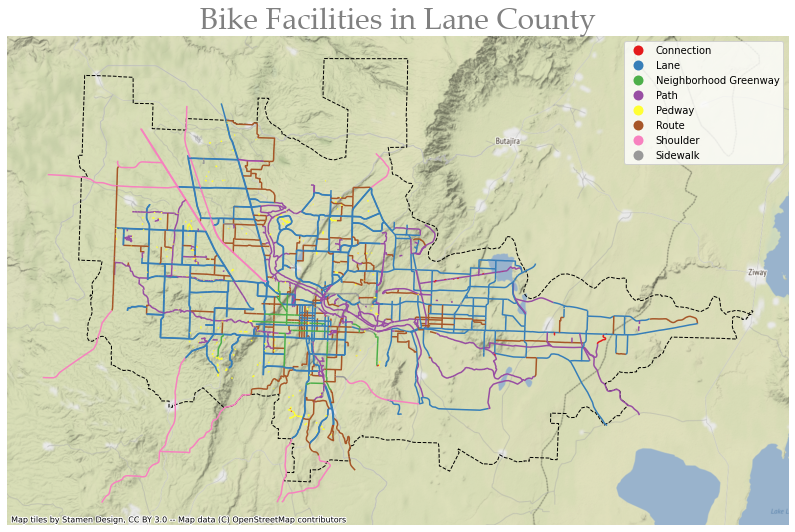

In [22]:
# color reference: https://matplotlib.org/tutorials/colors/colormaps.html
fig, ax = plt.subplots(figsize=(14, 12))
BikeFacility.plot(ax=ax, column='ftype', cmap='Set1', legend=True, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
ctx.add_basemap(ax)
plt.title("Bike Facilities in Lane County", fontsize=30, fontname="Palatino Linotype", color="grey")
ax.axis("off")
plt.show()

In [23]:
# Method 3 - Use Arcpy
import arcpy

In [24]:
import tempfile

In [25]:
#Create a temp directory using tempfile module to store SDE connection files
sdeTempPath = tempfile.mkdtemp()

In [26]:
#Setup SDE Connection
#Reference: https://desktop.arcgis.com/en/arcmap/latest/tools/data-management-toolbox/create-database-connection.htm
arcpy.CreateDatabaseConnection_management(sdeTempPath,
                                          'RLIDGeo.sde',
                                          'SQL_SERVER',
                                          'rliddb.int.lcog.org,5433',
                                          'OPERATING_SYSTEM_AUTH',
                                          '#', 
                                          '#', 
                                          '#',
                                          'RLIDGeo')
# Or create a .sde file using ArcGIS
# conn = arcpy.ArcSDESQLExecute(r'C:\Users\clid1852\Downloads\OSA@rliddb.int.lcog.org_RLIDGeo.sde')

<Result 'C:\\Users\\clid1852\\AppData\\Local\\Temp\\tmp3ckd0_ck\\RLIDGeo.sde'>

In [32]:
import os

In [33]:
os.path.join(sdeTempPath,'RLIDGeo.sde')

'C:\\Users\\clid1852\\AppData\\Local\\Temp\\tmp3ckd0_ck\\RLIDGeo.sde'

In [34]:
conn = arcpy.ArcSDESQLExecute(os.path.join(sdeTempPath,'RLIDGeo.sde'))

In [35]:
results = conn.execute("select ftype from dbo.BikeFacility") 

In [36]:
type(results)

list

In [37]:
results[:10]

[['Lane'],
 ['Lane'],
 ['Path'],
 ['Path'],
 ['Path'],
 ['Route'],
 ['Lane'],
 ['Lane'],
 ['Lane'],
 ['Lane']]